# STRF Estimation.  

**This notebooks tests python implementation of strf direct fit _strfpy_**




In [30]:
# Ignore Warnings
from warnings import simplefilter
simplefilter('ignore')

%reload_ext autoreload
%autoreload 2

In [31]:
# Dependencies - General Stuff
import sys
import os
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
from glob import glob

# Depednecies from Theunissen Lab
# sys.path.append("/Users/frederictheunissen/Code/soundsig/")
from soundsig.sound import BioSound

# strfpy
from strfpy.makePSTH import SpikeResponse
from strfpy import findDatasets, preprocSound, strfSetup, trnDirectFit, plotTfrep
# from strflab import preprocess_sound, srdata2strflab, linInit, strfData, trnDirectFit, strfOpt


%matplotlib widget
plt.ion();

Set up the path

In [32]:
# Change this if you move around files
path_base = os.path.join('/mnt/Data/kailin/crcns')

# For example you can specify an entire path
# path_base = '/Users/frederictheunissen/Documents/Classes/Summer Course/2016/theunissen_tutorials'

data_files = glob(os.path.join(path_base, 'data', '*', '*', '*'))
# spikes = glob('../data/*/*/*')


In [33]:
path_base, data_files

('/mnt/Data/kailin/crcns',
 ['/mnt/Data/kailin/crcns/data/l2a_bad/conspecific/stim15',
  '/mnt/Data/kailin/crcns/data/l2a_bad/conspecific/spike4',
  '/mnt/Data/kailin/crcns/data/l2a_bad/conspecific/stim11',
  '/mnt/Data/kailin/crcns/data/l2a_bad/conspecific/spike2',
  '/mnt/Data/kailin/crcns/data/l2a_bad/conspecific/spike10',
  '/mnt/Data/kailin/crcns/data/l2a_bad/conspecific/stim2',
  '/mnt/Data/kailin/crcns/data/l2a_bad/conspecific/spike1',
  '/mnt/Data/kailin/crcns/data/l2a_bad/conspecific/stim7',
  '/mnt/Data/kailin/crcns/data/l2a_bad/conspecific/spike16',
  '/mnt/Data/kailin/crcns/data/l2a_bad/conspecific/spike18',
  '/mnt/Data/kailin/crcns/data/l2a_bad/conspecific/spike12',
  '/mnt/Data/kailin/crcns/data/l2a_bad/conspecific/spike15',
  '/mnt/Data/kailin/crcns/data/l2a_bad/conspecific/stim16',
  '/mnt/Data/kailin/crcns/data/l2a_bad/conspecific/stim10',
  '/mnt/Data/kailin/crcns/data/l2a_bad/conspecific/spike11',
  '/mnt/Data/kailin/crcns/data/l2a_bad/conspecific/spike3',
  '/mnt/D

In [34]:
rootDir = os.path.join(path_base, 'matlab')
spath = os.path.join(rootDir, 'strflab')
dfpath = os.path.join(rootDir, 'direct_fit')
vpath = os.path.join(rootDir, 'validation')
ppath = os.path.join(rootDir, 'preprocessing')
dataDir = os.path.join(rootDir, '..', 'data')  # contains stim/response pairs
stimsDir = os.path.join(dataDir, 'all_stims')  # contains the .wav files
# strflab.util.addpath(spath)
# strflab.util.addpath(dfpath)
# strflab.util.addpath(vpath)
# strflab.util.addpath(ppath)


load and visualize single unit data from Theunissen lab

In [35]:
# Specify the directory for three brain regions and three example neurons in each
cellDirName = 'l2a_avg'
cellDir = os.path.join(dataDir, cellDirName)



In [36]:
cellDir

'/mnt/Data/kailin/crcns/matlab/../data/l2a_avg'

In [37]:
# Get the stimulus and response files from the cell directory
datasets = findDatasets.find_datasets(cellDir, stimsDir, 'conspecific')
cellStimDir = datasets[0]['dirname']
stimFiles = datasets[0]['srPairs']['stimFiles']  # paths to .wav files
respFiles = datasets[0]['srPairs']['respFiles']  # paths to spike* files


In [38]:
# Preprocess the sound stimuli by taking the short time Fourier transform, and preprocess the raw spike
# times into PSTHs for each stim/response pair.
preprocDir = os.path.join(cellStimDir, 'preproc') # cache the preprocessed data here
os.makedirs(preprocDir, exist_ok=True)
preprocOptions = {} # we'll leave this empty and use default options


In [ ]:
# set up datasets

srData = preprocSound.preprocess_sound(stimFiles, respFiles, 'ft', preprocOptions, preprocDir)


pairCount = len(srData['datasets']) # number of stim/response pairs
nStimChannels = srData['nStimChannels']
strfLength = 75
strfDelays = np.arange(strfLength)

In [ ]:
srData

{'stimSampleRate': 1000,
 'respSampleRate': 1000,
 'nStimChannels': 60,
 'datasets': [{'stim': array([[(array(['tfrep'], dtype='<U5'), array(['/Users/frederictheunissen/Documents/Classes/Summer Course/2012/theunissen_tutorials/directfit_tutorial/../data/all_stims/D54ABC42488F995C789F351A34316039.wav'],
                 dtype='<U157'), array([[(array(['ft'], dtype='<U2'), array([[0.000e+00],
                          [1.000e-03],
                          [2.000e-03],
                          ...,
                          [1.720e+00],
                          [1.721e+00],
                          [1.722e+00]]), array([[ 262.29508197,  393.44262295,  524.59016393,  655.73770492,
                            786.8852459 ,  918.03278689, 1049.18032787, 1180.32786885,
                           1311.47540984, 1442.62295082, 1573.7704918 , 1704.91803279,
                           1836.06557377, 1967.21311475, 2098.36065574, 2229.50819672,
                           2360.6557377 , 2491.80

set up strflab

In [ ]:
# Initialize the linear model
modelParams = strfSetup.linInit(nStimChannels, strfDelays)

modelParams

{'type': 'lin',
 'nIn': 60,
 'nWts': 4501,
 'delays': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74]),
 'w1': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'b1': 0,
 'outputNL': 'linear',
 'freqDomain': 0,
 'internal': {'compFwd': 1,
  'prevResp': None,
  'prevLinResp': None,
  'dataHash': nan}}

In [ ]:
# Convert srData into a format that strflab understands
allstim, allresp, groupIndex = strfSetup.srdata2strflab(srData, 0)

allstim, allresp, groupIndex

(array([[ 0.        ,  2.08021277,  8.99634705, ..., 14.22101437,
         15.65866657, 14.16822423],
        [ 0.        ,  8.57974755, 16.22516721, ..., 20.33514711,
         21.39102977, 19.33240622],
        [ 0.        , 11.96042304, 20.5943838 , ..., 20.52879081,
         24.05212586, 21.96705568],
        ...,
        [ 0.        , 15.77116218, 25.57996952, ..., 20.3939534 ,
         20.00570092, 21.90037239],
        [ 0.63988149, 15.19888002, 23.52371486, ..., 14.3746917 ,
         15.58685624, 18.90837885],
        [ 6.76822455, 13.17409322, 18.90319353, ..., 11.97554577,
         14.34065951, 15.45114667]]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.,  0.,  0., ..., 19., 19., 19.]))

In [ ]:
# Put stimulus and response and group assignments into global structure
global globDat
globDat = strfSetup.strfData(allstim, allresp, groupIndex)

globDat

{'stim': array([[ 0.        ,  2.08021277,  8.99634705, ..., 14.22101437,
         15.65866657, 14.16822423],
        [ 0.        ,  8.57974755, 16.22516721, ..., 20.33514711,
         21.39102977, 19.33240622],
        [ 0.        , 11.96042304, 20.5943838 , ..., 20.52879081,
         24.05212586, 21.96705568],
        ...,
        [ 0.        , 15.77116218, 25.57996952, ..., 20.3939534 ,
         20.00570092, 21.90037239],
        [ 0.63988149, 15.19888002, 23.52371486, ..., 14.3746917 ,
         15.58685624, 18.90837885],
        [ 6.76822455, 13.17409322, 18.90319353, ..., 11.97554577,
         14.34065951, 15.45114667]]),
 'resp': array([0., 0., 0., ..., 0., 0., 0.]),
 'nSample': 38765,
 'groupIdx': array([ 0.,  0.,  0., ..., 19., 19., 19.]),
 'dataHash': 3.666868387717434}

In [ ]:
# Create default optimization options structure
params, optOptions = trnDirectFit.trnDirectFit()
optOptions['display'] = 1

optOptions

{'funcName': 'trnDirectFit',
 'tolerances': [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 5e-05],
 'sparsenesses': [0, 1, 2, 6],
 'separable': 0,
 'timeVaryingPSTH': 0,
 'timeVaryingPSTHTau': 41,
 'stimSampleRate': 1000,
 'respSampleRate': 1000,
 'infoFreqCutoff': 100,
 'infoWindowSize': 0.5,
 'outputDir': '/tmp',
 'display': 1}

In [86]:
# Run direct fit optimization on all of the data
datIdx = np.arange(len(allresp)) # the indexes of training data (all of it)
modelParamsTrained, options = strfSetup.strfOpt(modelParams, datIdx, optOptions, globDat)

Now calculating stim autocorrelation
Done auto-correlation calculation
The autocorrelation took 55.50262287500027 seconds.
Now doing cross-correlation calculation.
Done calculation of cross-correlation.
Now calculating JN cross-correlation.
Done calculation of JN cross-correlation.
Calculating strfs for each tol value.


KeyboardInterrupt: 

compute prediction for each stim/response pair and concatenate them, <br>
also split the real PSTHs in half and concatenate them across pairs

In [ ]:
pairCount = len(srData['datasets'])
predictionSets = [None] * pairCount
concatPredResp = np.array([])
concatPsthHalf1 = np.array([])
concatPsthHalf2 = np.array([])

strfFrequencies = -1

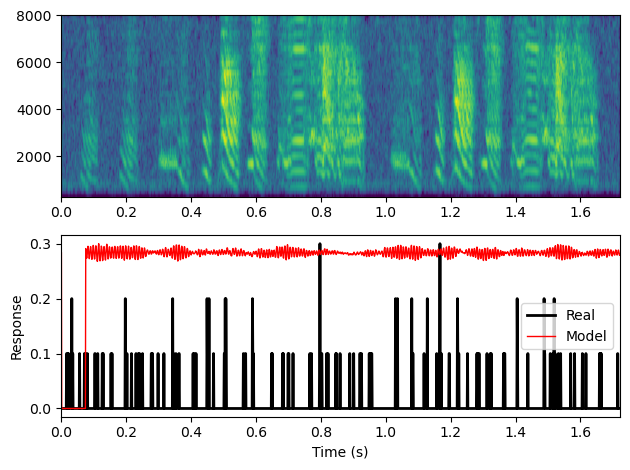

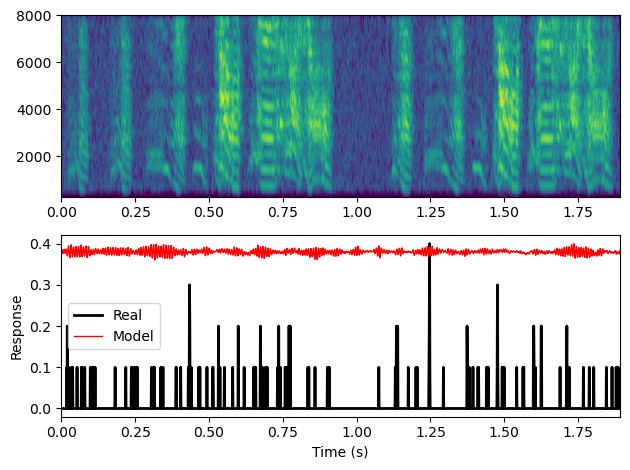

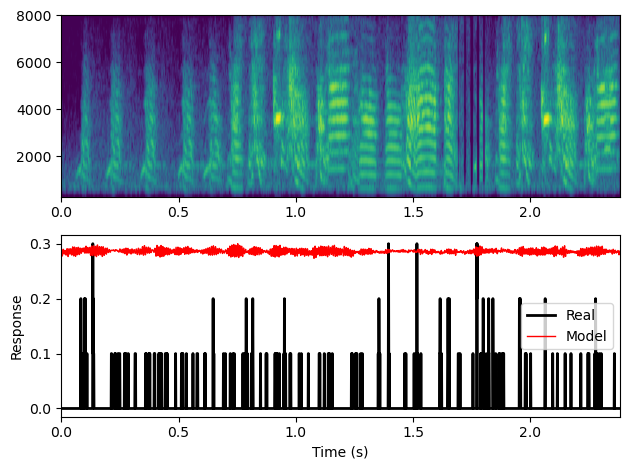

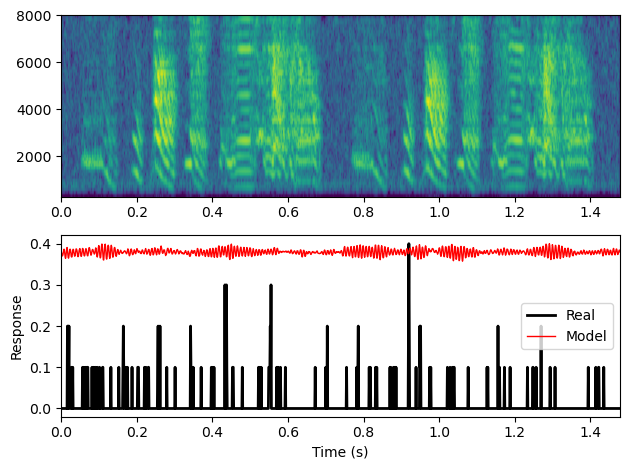

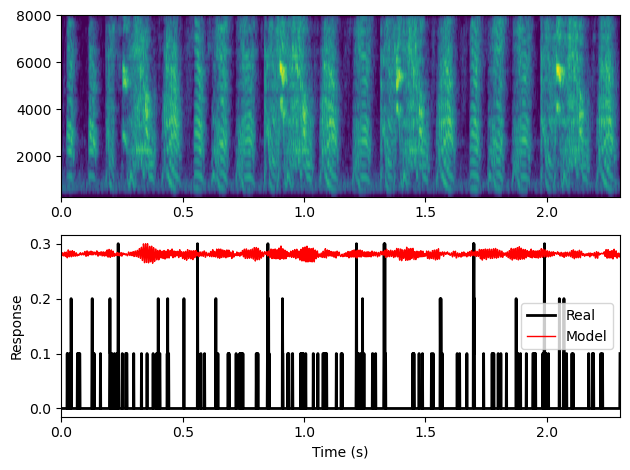

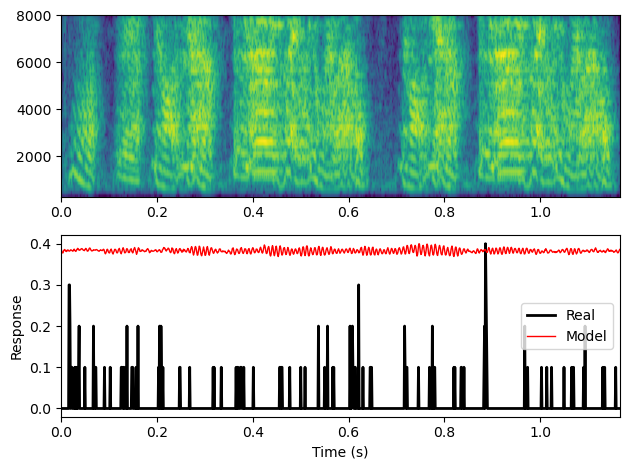

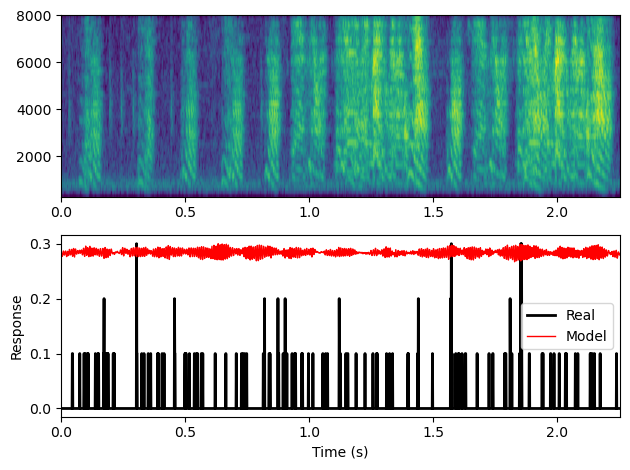

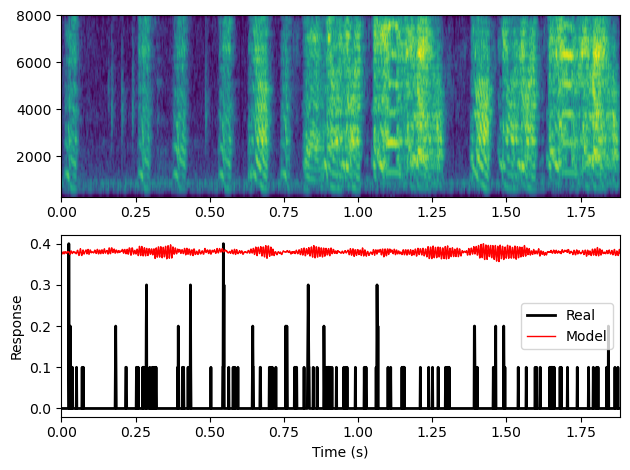

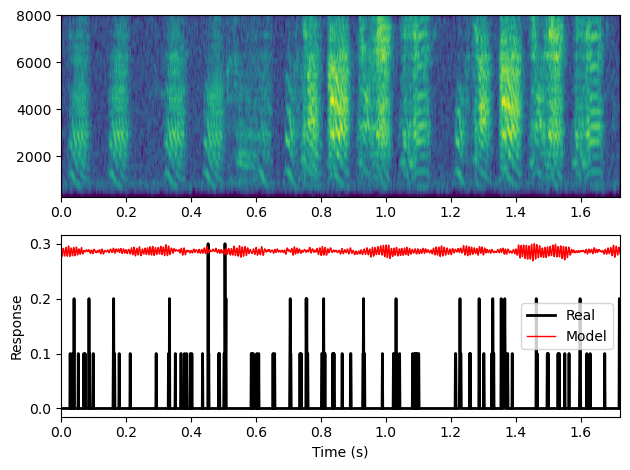

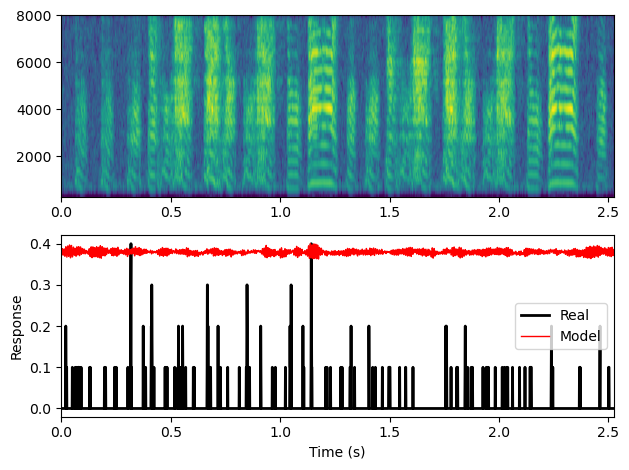

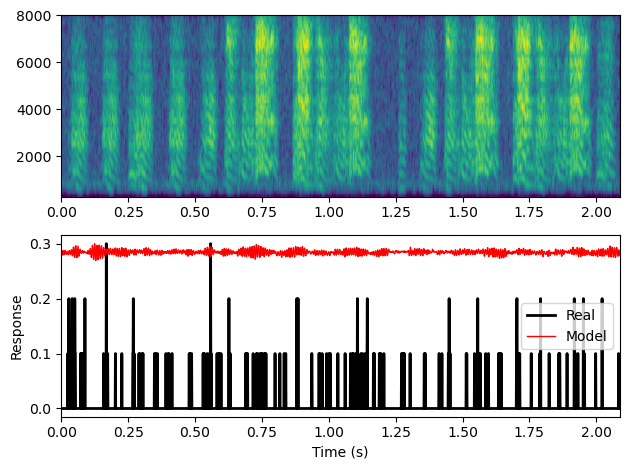

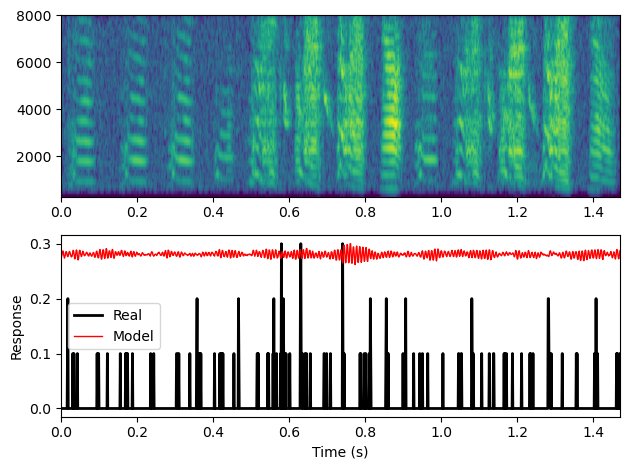

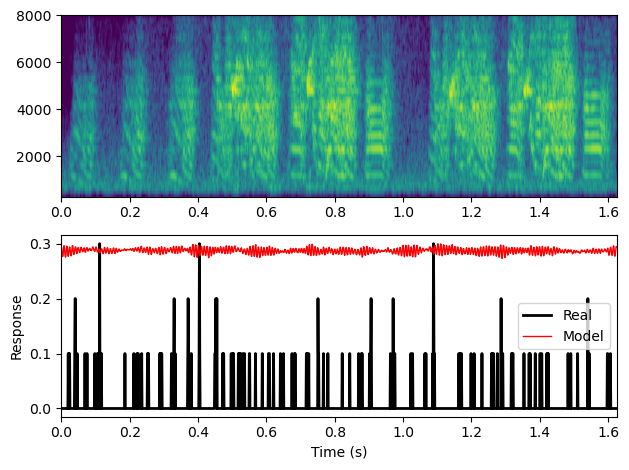

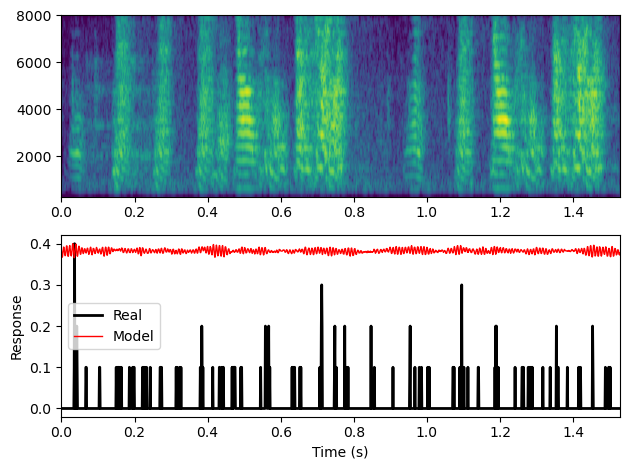

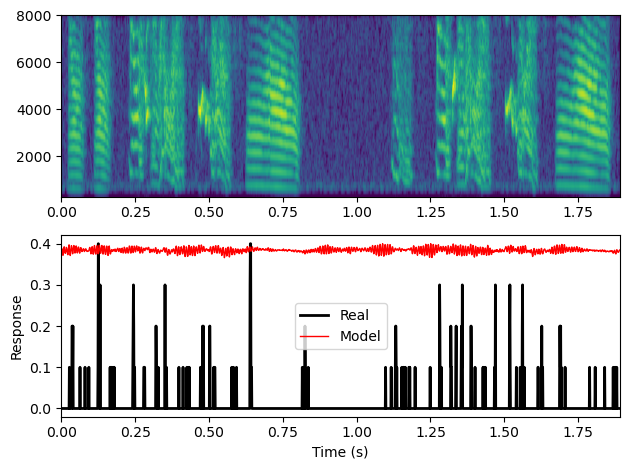

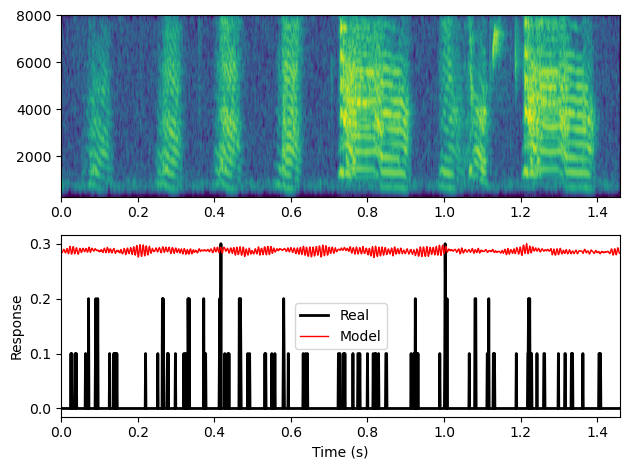

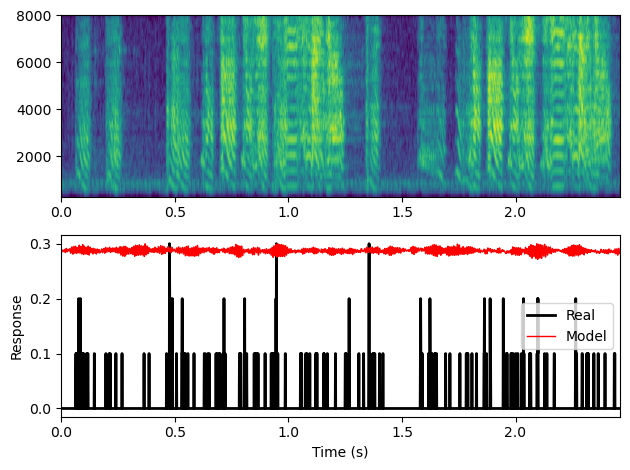

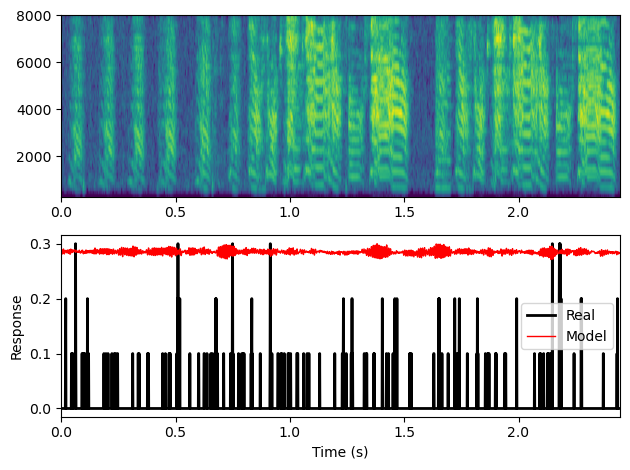

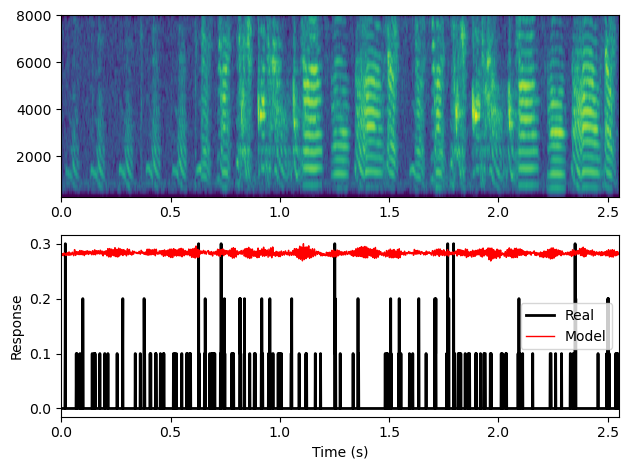

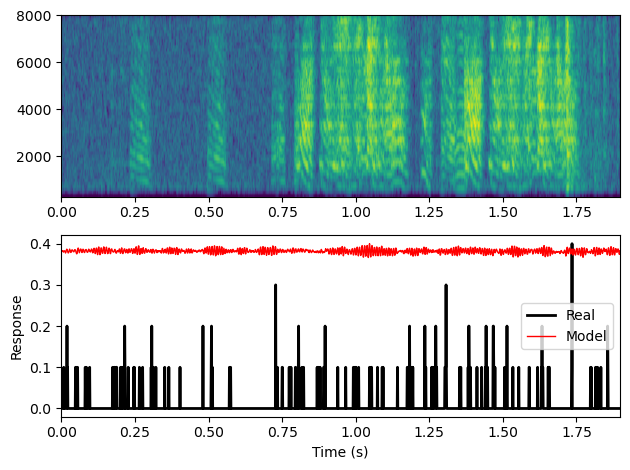

In [ ]:
for k in range(pairCount):
    # get stim and response
    ds = srData['datasets'][k]
    tfrep = pd.DataFrame(ds['stim'].flatten()['tfrep'][0].flatten())
    strfFrequencies = tfrep['f']


    strflabIndx = np.where(groupIndex == k)[0]
    stim = allstim[strflabIndx, :]
    resp = allresp[strflabIndx]

    # compute prediction
    modelParamsTemp, predResp = strfSetup.strfFwd(modelParamsTrained, strflabIndx, globDat)
    del modelParamsTemp

    # fix any NaNs in response
    predResp = predResp[0]
    predResp[np.isnan(predResp)] = 0


    # rectify response
    predResp[predResp < 0] = 0

    # scale predicted response
    predResp = (predResp / max(predResp)) * max(resp)

    # concatenate PSTH halves and predicted PSTH for this trial
    stimLengthMs = (stim.shape[0] / srData['stimSampleRate']) * 1e3
    psthdata = preprocSound.split_psth(ds['resp']['rawSpikeTimes'], stimLengthMs)
    numTrials = len(ds['resp']['rawSpikeTimes'])

    concatPredResp = np.concatenate((concatPredResp, predResp))
    concatPsthHalf1 = np.concatenate((concatPsthHalf1, psthdata['psth_half1']))
    concatPsthHalf2 = np.concatenate((concatPsthHalf2, psthdata['psth_half2']))
    %matplotlib inline
    plt.figure()
    rsint = 1 / srData['respSampleRate']
    tresp = np.arange(len(resp)) * rsint
    tpresp = np.arange(len(predResp)) * rsint

    plt.subplot(2,1,1)
    plt.imshow(tfrep['spec'][0], aspect='auto', origin='lower'
           , extent=[tfrep['t'][0][0][0], tfrep['t'][0][-1][0], tfrep['f'][0][0][0], tfrep['f'][0][0][-1]])

    

    # plot response and prediction
    plt.subplot(2,1,2)
    plt.plot(tresp, resp, 'k-', linewidth=2)
    plt.plot(tpresp, predResp, 'r-', linewidth=1)
    plt.legend(['Real', 'Model'])
    plt.xlim([tresp[0], tresp[-1]])
    plt.xlabel('Time (s)')
    plt.ylabel('Response')
    plt.tight_layout()
    plt.show()

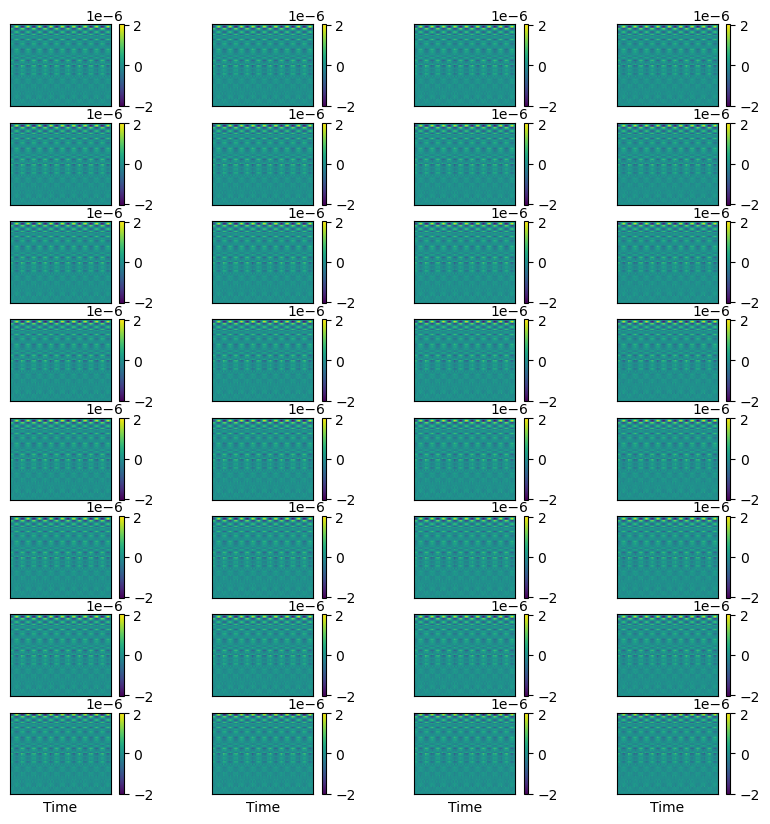

In [67]:
%matplotlib inline
# Create a list of file names for each tolerance
strfFiles = [os.path.join(options['outputDir'], f'strfResult_Tol{k}.npz') for k in range(1, len(options['tolerances']) + 1)]

# Choose the temporal section of the STRF that is used in the convolution
halfIndx = int(np.ceil(np.max(np.abs(modelParams['delays']))) + 1)  # This is the point corresponding to zero
startIndx = int(halfIndx + round(np.min(modelParams['delays'])))
endIndx = int(halfIndx + round(np.max(modelParams['delays'])))
# strfRng = np.arange(startIndx, endIndx)

fig, axs = plt.subplots(len(options['tolerances']), len(options['sparsenesses']), figsize=(10, 10))
maxall = np.zeros((len(options['tolerances']), len(options['sparsenesses'])))

for k in range(len(options['tolerances'])):
    
    # Load filters obtained for that tolerance
    svars = np.load(strfFiles[k], allow_pickle=True)
    # strfsJN is an MxPxT matrix, where M=# of channels, P=# of STRF delays, 
    # T = # of stim/response pairs, each element strfsJN[:, :, k] is a STRF 
    # constructed from fitting all but pair k to the data.
    strfsJN = svars['STRFJN_Cell']
    
    # strfsJN_std is also an MxPxT matrix. Element strfsJN_std[:, :, k]
    # is the STRF standard deviation across the set of all jacknifed STRFs 
    # excluding the kth STRF
    strfsJN_std = svars['STRFJNstd_Cell']
    
    # strfMean is the mean across all jacknifed STRFs for a given tolerance
    strfMean = svars['STRF_Cell']
    
    # strfStdMean is the average standard deviation across all jacknifed
    # STRFs for a given tolerance
    strfStdMean = np.mean(strfsJN_std, axis=2)
    
    # Clear the variable to free up memory
    del svars
    
    for q in range(len(options['sparsenesses'])):
        ax = axs[k, q]
        
        smoothedMeanStrf = trnDirectFit.df_fast_filter_filter(strfMean, strfStdMean, options['sparsenesses'][q])
        # smoothedMeanStrf = strfMean

        im = ax.imshow(np.real(smoothedMeanStrf[:, startIndx:endIndx+1])
                       , cmap='viridis'
                       , vmin=-np.max(np.abs(np.real(smoothedMeanStrf[:, startIndx:endIndx+1])))
                       , vmax=np.max(np.abs(np.real(smoothedMeanStrf[:, startIndx:endIndx+1])))
                      )
        maxall[k, q] = np.max(np.abs(np.real(smoothedMeanStrf[:, startIndx:endIndx+1])))
        
        fig.colorbar(im, ax=ax)
        # im.set_clim(-maxall[k, q], maxall[k, q])
        ax.set_xticks([])
        ax.set_yticks([])
        if k == len(options['tolerances']) - 1:
            ax.set_xlabel('Time')

        

plt.show()


In [ ]:
import pickle 
pickle.dump(modelParams,open("/tmp/modelParams.pkl",'wb'))
pickle.dump(datIdx,open("/tmp/datIdx.pkl",'wb'))
pickle.dump(optOptions,open("/tmp/optOptions.pkl",'wb'))
pickle.dump(globDat,open("/tmp/globDat.pkl",'wb'))

In [ ]:
tmp_modelParams = pickle.load(open("/tmp/modelParams.pkl",'rb'))
tmp_datIdx = pickle.load(open("/tmp/datIdx.pkl",'rb'))
tmp_optOptions = pickle.load(open("/tmp/optOptions.pkl",'rb'))
tmp_globDat = pickle.load(open("/tmp/globDat.pkl",'rb'))

In [ ]:
globals()[optOptions['trnDirectFit.trnDirectFit']](modelParams, datIdx, optOptions, globDat, 1)


In [ ]:
trnDirectFit.trnDirectFit(modelParams, datIdx, optOptions, globDat, 1)